In [1]:
# Obtiene el onset y withdrawal a partir de la precipitación.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy.stats import bootstrap

import warnings
warnings.filterwarnings("ignore")

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [2]:
# Procesar o cargar la precipitación
load_pre = True

# Rutas de archivos.
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Cantidad de años.
year_r = [1981, 2020]
# Fechas límite de inicio y fin de onset y withdrawal.
# 1° de mayo, 20 de julio, 1° de septiembre, 15 de noviembre
ini = [ [121, 196], [244, 319] ]
# Utilizar el onset al inicio o al final de la racha de precipitación.
rec = [True, False]
lim = 6
step = [0.5, 0.05]
# Para cálculo de series de tiempo y tendencias.
media_5 = [None] * 4
tend    = [None] * 4

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r): os.mkdir(path_r)

# Cargamos el archivo.
if load_pre:
    df = pd.read_csv( path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
    df.index = pd.to_datetime(df.index)
# Procesamos la información y creamos el archivo.
else:
    # Se abre el archivo histórico y el del año en curso.
    ds = xr.open_mfdataset( [ path_nc + x for x in names[0:2] ],
        combine = "nested", concat_dim = "time", parallel = True )

    # Se carga el contorno de México.
    gdf = gpd.read_file(path_shp + names[2])

    # Se obtiene el contorno de los países.
    gdf["boundary"] = gdf.boundary

    # Se establece el datum de los datos.
    ds = ds.rio.write_crs(gdf.crs)

    # Se hace la máscara de México.
    clip = ds.rio.clip(
        gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
        gdf.crs, drop=False, invert=False).drop("spatial_ref")

    # Cantidad de días a promediar.
    d = 20

    # Precipitación diaria promedio en toda la cuenca.
    df = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )

    # Media móvil de precipitación centrada a 15 días.
    df["precip"] = ( df["precip"].rolling( window = d, center = True).mean() )
    df.columns = ["Cuenca"]

    # Se guardan los datos.
    df.to_csv(path_d + "pre_daily_CHIRPS.csv")

# Escogemos los años de precipitación a utilizar.
df = df[ df.index.year.isin( range(year_r[0], year_r[1] + 1) ) ]

Umbral: 2.3 mm/día, 20 días consecutivos, Pendiente: 0.312
Umbral: 2.5 mm/día, 20 días consecutivos, Pendiente: 0.371
Umbral: 2.7 mm/día, 20 días consecutivos, Pendiente: 0.358


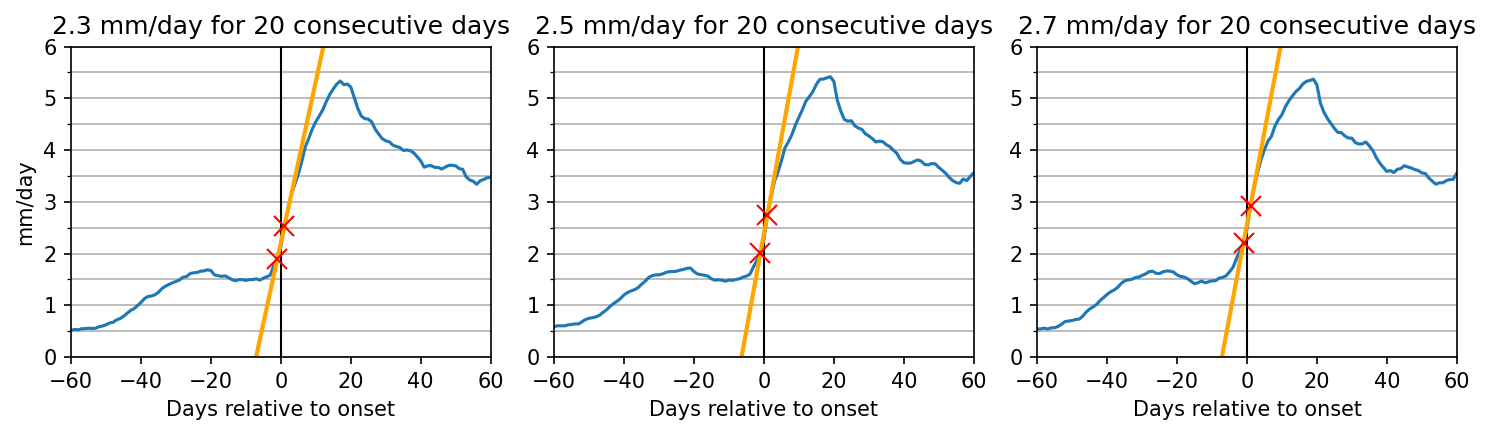

In [3]:
df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.3, 2.5, 2.7]
n = 20

title = "onset_criteria_CHIRPS.png"

fig, axes = plt.subplots(1, len(umbral))
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

# Inicio o fin de la racha.
k = 0
if rec[0]: k = n

# Probamos para varios umbrales.
for i_u, u in enumerate(umbral):
    df_mean_ind = pd.DataFrame( df_mean.copy(), columns = ["Cuenca"] )

    c = "Cuenca"

    # Nombre de las columnas dummy.
    proc = [c]
    for i in range(0, n): proc.append(c + "_" + str(i)) 

    # Traslapa los últimos n días 
    # y da un valor de 1 a cada día 
    # que cumpla con el umbral.
    for i, p in enumerate(proc[1:]):
        df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
        df_mean_ind[p].clip( upper = u, inplace = True )
        df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p] == u, 0 )
        df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p] <  u, 1 )

    # El índice es uno si los n
    # cumplen con el umbral.
    ind = "Index_" + c
    df_mean_ind[ind] = 0
    for i in range(n): df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
    df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n, 0 )
    df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] <  n, 1 )
    df_mean_ind.drop( proc[1:], axis = 1, inplace = True )

    # Crea una tabla con los valores anuales.
    col = []
    name = "Cuenca"
    col.append(name + " - Onset")
    col.append(name + " - Withdrawal")

    date = pd.DataFrame()
    years = range(year_r[0], year_r[1] + 1)

    for j in years:
        # Solo utilizamos valores entre los límites.
        df_year = df_mean_ind[ (df_mean_ind.index.year == j)
            & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k ) )
            & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k ) ) ]

        row = []

        # Fechas.
        row.append( df_year.iloc[:, 1].idxmax() )
        row.append( df_year.iloc[::-1, 1].idxmax() )

        # Agregamos la fila al DataFrame.
        date = date.append([row])

    # Damos formato a las columnas y al índice.
    date.columns = col
    date.index = years
    date.index.name = "Año"
        
    # Recorremos al inicio de la racha de días de precipitación.
    if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n, 'D')
    # Longitud de la temporada.
    date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

    # Calculamos el shift necesario para alinear las fechas.
    shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
    delta = shift.max()
    shift = shift.max() - shift

    # Creamos un DataFrame con año
    # como columnas y días como filas.
    pre_df = pd.DataFrame( df_mean.copy(), columns = [df_mean.columns[0]] )
    pre_df["Año"] = pre_df.index.year
    pre_df["Día"] = pre_df.index.dayofyear

    # Convertimos los años a columnas.
    pre_df = pre_df.pivot(index = "Día", columns = "Año")
    pre_df.columns = pre_df.columns.droplevel(0)

    # Eliminamos el 2021.
    pre_df = pre_df.iloc[:, :-1]

    # Alineamos las series de tiempo.
    for j in pre_df.columns: pre_df[j] = pre_df[j].shift(shift[j])

    # Promediamos y seleccionamos 120 días.
    pre_df = pre_df.mean(axis = 1)
    pre_df = pre_df.loc[delta - 60: delta + 60]
    pre_df.index = range(-60, 61)

    # Graficamos.
    axes[i_u].plot( (0, 0), (0, 7), color = "k",
        linewidth = 1 )
    pre_df.plot(ax = axes[i_u])

    axes[i_u].set_title(f"{u} mm/day for {n} consecutive days")
    axes[i_u].set_xlim(-60, 60)
    axes[i_u].set_ylim(0, lim)
    axes[i_u].set_xlabel("Days relative to onset")

    if i_u == 0:  axes[i_u].set_ylabel("mm/day")

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        ax.grid( visible = True, which = "both", axis ="y" )

    # Pendiente del incremento de lluvia.
    p = 1
    y_1 = pre_df.loc[-p]
    y_2 = pre_df.loc[ p]
    x_1 = -p
    x_2 =  p
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    print( f"Umbral: {u} mm/día, {n} días consecutivos, " + 
        f"Pendiente: {m:.3f}" )
    axes[i_u].plot( ( x_1 + ( 0 - y_1 ) / m, 
        x_1 + ( lim - y_1 ) / m ), (0, lim),
        color = "orange", linewidth = 2 )
    axes[i_u].plot( x_1, y_1, marker = "x",
        markersize = 10, color = "r")
    axes[i_u].plot( x_2, y_2, marker = "x",
        markersize = 10, color = "r")

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    fig.savefig( path_r + title )

Umbral: 1.5 mm/día, 20 días consecutivos, Pendiente: 0.495
Umbral: 1.7 mm/día, 20 días consecutivos, Pendiente: 0.513
Umbral: 1.9 mm/día, 20 días consecutivos, Pendiente: 0.482


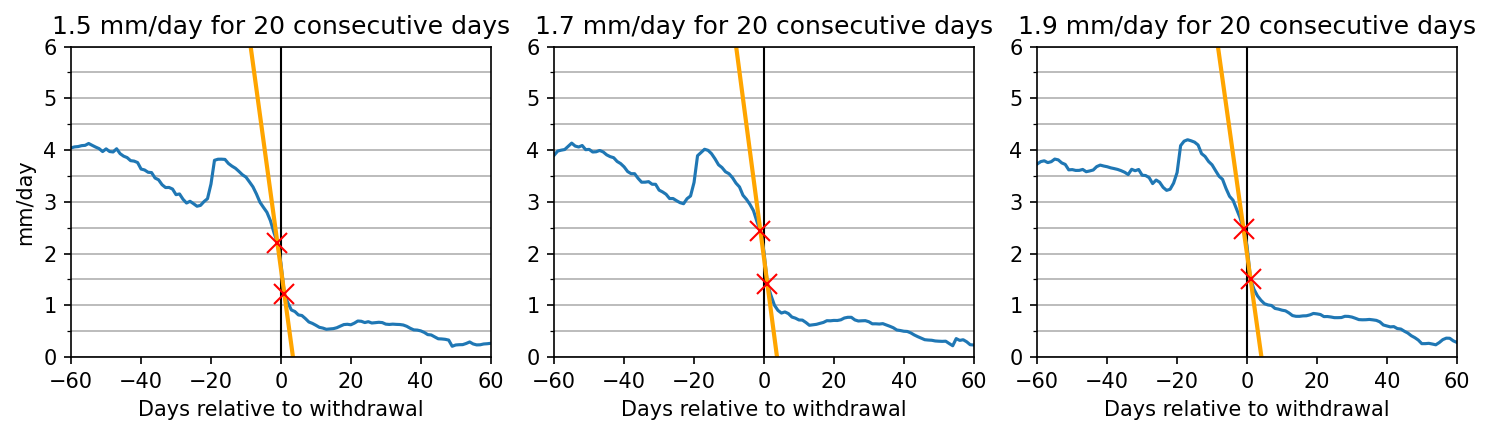

In [4]:
df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [1.5, 1.7, 1.9]
n = 20

title = "withdrawal_criteria_CHIRPS.png"

fig, axes = plt.subplots(1, len(umbral))
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

k = 0
if rec[1]: k = n
    
for i_u, u in enumerate(umbral):
    df_mean_ind = pd.DataFrame( df_mean.copy(), columns = ["Cuenca"] )

    c = "Cuenca"

    # Nombre de las columnas dummy.
    proc = [c]
    for i in range(0, n): proc.append(c + "_" + str(i)) 

    # Traslapa los últimos n días 
    # y da un valor de 1 a cada día 
    # que cumpla con el umbral.
    for i, p in enumerate(proc[1:]):
        df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
        df_mean_ind[p].clip( upper = u, inplace = True )
        df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p] == u, 0)
        df_mean_ind[p] = df_mean_ind[p].where( df_mean_ind[p]  < u, 1)

    # El índice es uno si los n
    # cumplen con el umbral.
    ind = "Index_" + c
    df_mean_ind[ind] = 0
    for i in range(n): df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
    df_mean_ind[ind] = df_mean_ind[ind].where(df_mean_ind[ind] == n, 0)
    df_mean_ind[ind] = df_mean_ind[ind].where(df_mean_ind[ind] < n, 1)
    df_mean_ind.drop(proc[1:], axis = 1, inplace = True)

    # Crea una tabla con los valores anuales.
    col = []
    name = "Cuenca"
    col.append(name + " - Onset")
    col.append(name + " - Withdrawal")

    date = pd.DataFrame()
    years = range(year_r[0], year_r[1] + 1)

    for j in years:
        # Solo utilizamos valores entre mayo y diciembre.
        df_year = df_mean_ind[ (df_mean_ind.index.year == j)
            & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k ) )
            & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k ) ) ]

        row = []

        # Fechas.
        row.append( df_year.iloc[:, 1].idxmax() )
        row.append( df_year.iloc[::-1, 1].idxmax() )

        # Agregamos la fila al DataFrame.
        date = date.append([row])

    # Damos formato a las columnas y al índice.
    date.columns = col
    date.index = years
    date.index.name = "Año"
        
    # Recorremos al inicio de la racha de días de precipitación.
    if rec[1]: date.iloc[:, 0] = date.iloc[:, 0] + np.timedelta64(n, 'D')
    # Longitud de la temporada.
    date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

    # Calculamos el shift necesario para alinear las fechas.
    shift = date.iloc[:, 1].apply(lambda x: x.dayofyear)
    delta = shift.max()
    shift = shift.max() - shift

    # Creamos un DataFrame con año
    # como columnas y días como filas.
    pre_df = pd.DataFrame( df_mean.copy(), columns = [df_mean.columns[0]] )
    pre_df["Año"] = pre_df.index.year
    pre_df["Día"] = pre_df.index.dayofyear

    # Convertimos los años a columnas.
    pre_df = pre_df.pivot(index = "Día", columns = "Año")
    pre_df.columns = pre_df.columns.droplevel(0)

    # Eliminamos el 2021.
    pre_df = pre_df.iloc[:, :-1]

    # Alineamos las series de tiempo.
    for j in pre_df.columns: pre_df[j] = pre_df[j].shift(shift[j])

    # Promediamos y seleccionamos 120 días.
    pre_df = pre_df.mean(axis = 1)
    a = pre_df[0:60]
    a.index = np.arange(367, 367 + 60)
    pre_df = pre_df.append(a)
    pre_df = pre_df.loc[delta - 60: delta + 60]
    pre_df.index = range(-60, 61)

    # Graficamos.
    axes[i_u].plot( (0, 0), (0, 7), color = "k", linewidth = 1 )
    pre_df.plot(ax = axes[i_u])

    axes[i_u].set_title(f"{u} mm/day for {n} consecutive days")
    axes[i_u].set_xlim(-60, 60)
    axes[i_u].set_ylim(0, lim)

    # Pendiente del incremento de lluvia.
    y_1 = pre_df.loc[-1]
    y_2 = pre_df.loc[ 1]
    x_1 = -1
    x_2 =  1
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    print( f"Umbral: {u} mm/día, {n} días consecutivos, " + 
        f"Pendiente: {-m:.3f}")
    axes[i_u].plot( ( x_1 + ( 0 - y_1 ) / m, x_1 + ( lim - y_1 ) / m ),
        (0, lim), color = "orange", linewidth = 2 )
    axes[i_u].plot( x_1, y_1, marker = "x", markersize = 10, color = "r")
    axes[i_u].plot( x_2, y_2, marker = "x", markersize = 10, color = "r")
    axes[i_u].set_xlabel("Days relative to withdrawal")

    if i_u == 0:  axes[i_u].set_ylabel("mm/day")

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        ax.grid( visible = True, which = "both", axis ="y" )

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    fig.savefig( path_r + title )

Umbral: 2.5 mm/día, 20 días consecutivos, Pendiente: 0.371
Umbral: 1.7 mm/día, 20 días consecutivos, Pendiente: -0.509


,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length,Onset - date,Withdrawal - date
count,40.000000,40.000000,40,1970-02-10 00:00:00.000000000,1970-02-10 00:00:00.000000000
mean,156.275000,287.275000,131 days 00:00:00,1970-06-06 06:36:00.000000000,1970-10-15 06:36:00.000000000
std,14.322275,16.106994,22 days 17:36:30.534389323,1970-01-15 07:44:04.568828469,1970-01-17 02:34:04.283461944
min,129.000000,257.000000,91 days 00:00:00,1970-05-10 00:00:00.000000000,1970-09-15 00:00:00.000000000
25%,146.500000,275.750000,114 days 18:00:00,1970-05-27 12:00:00.000000000,1970-10-03 18:00:00.000000000
50%,160.500000,287.000000,132 days 00:00:00,1970-06-10 12:00:00.000000000,1970-10-15 00:00:00.000000000
75%,166.500000,295.000000,144 days 00:00:00,1970-06-16 12:00:00.000000000,1970-10-23 00:00:00.000000000
max,177.000000,318.000000,189 days 00:00:00,1970-06-27 00:00:00.000000000,1970-11-15 00:00:00.000000000


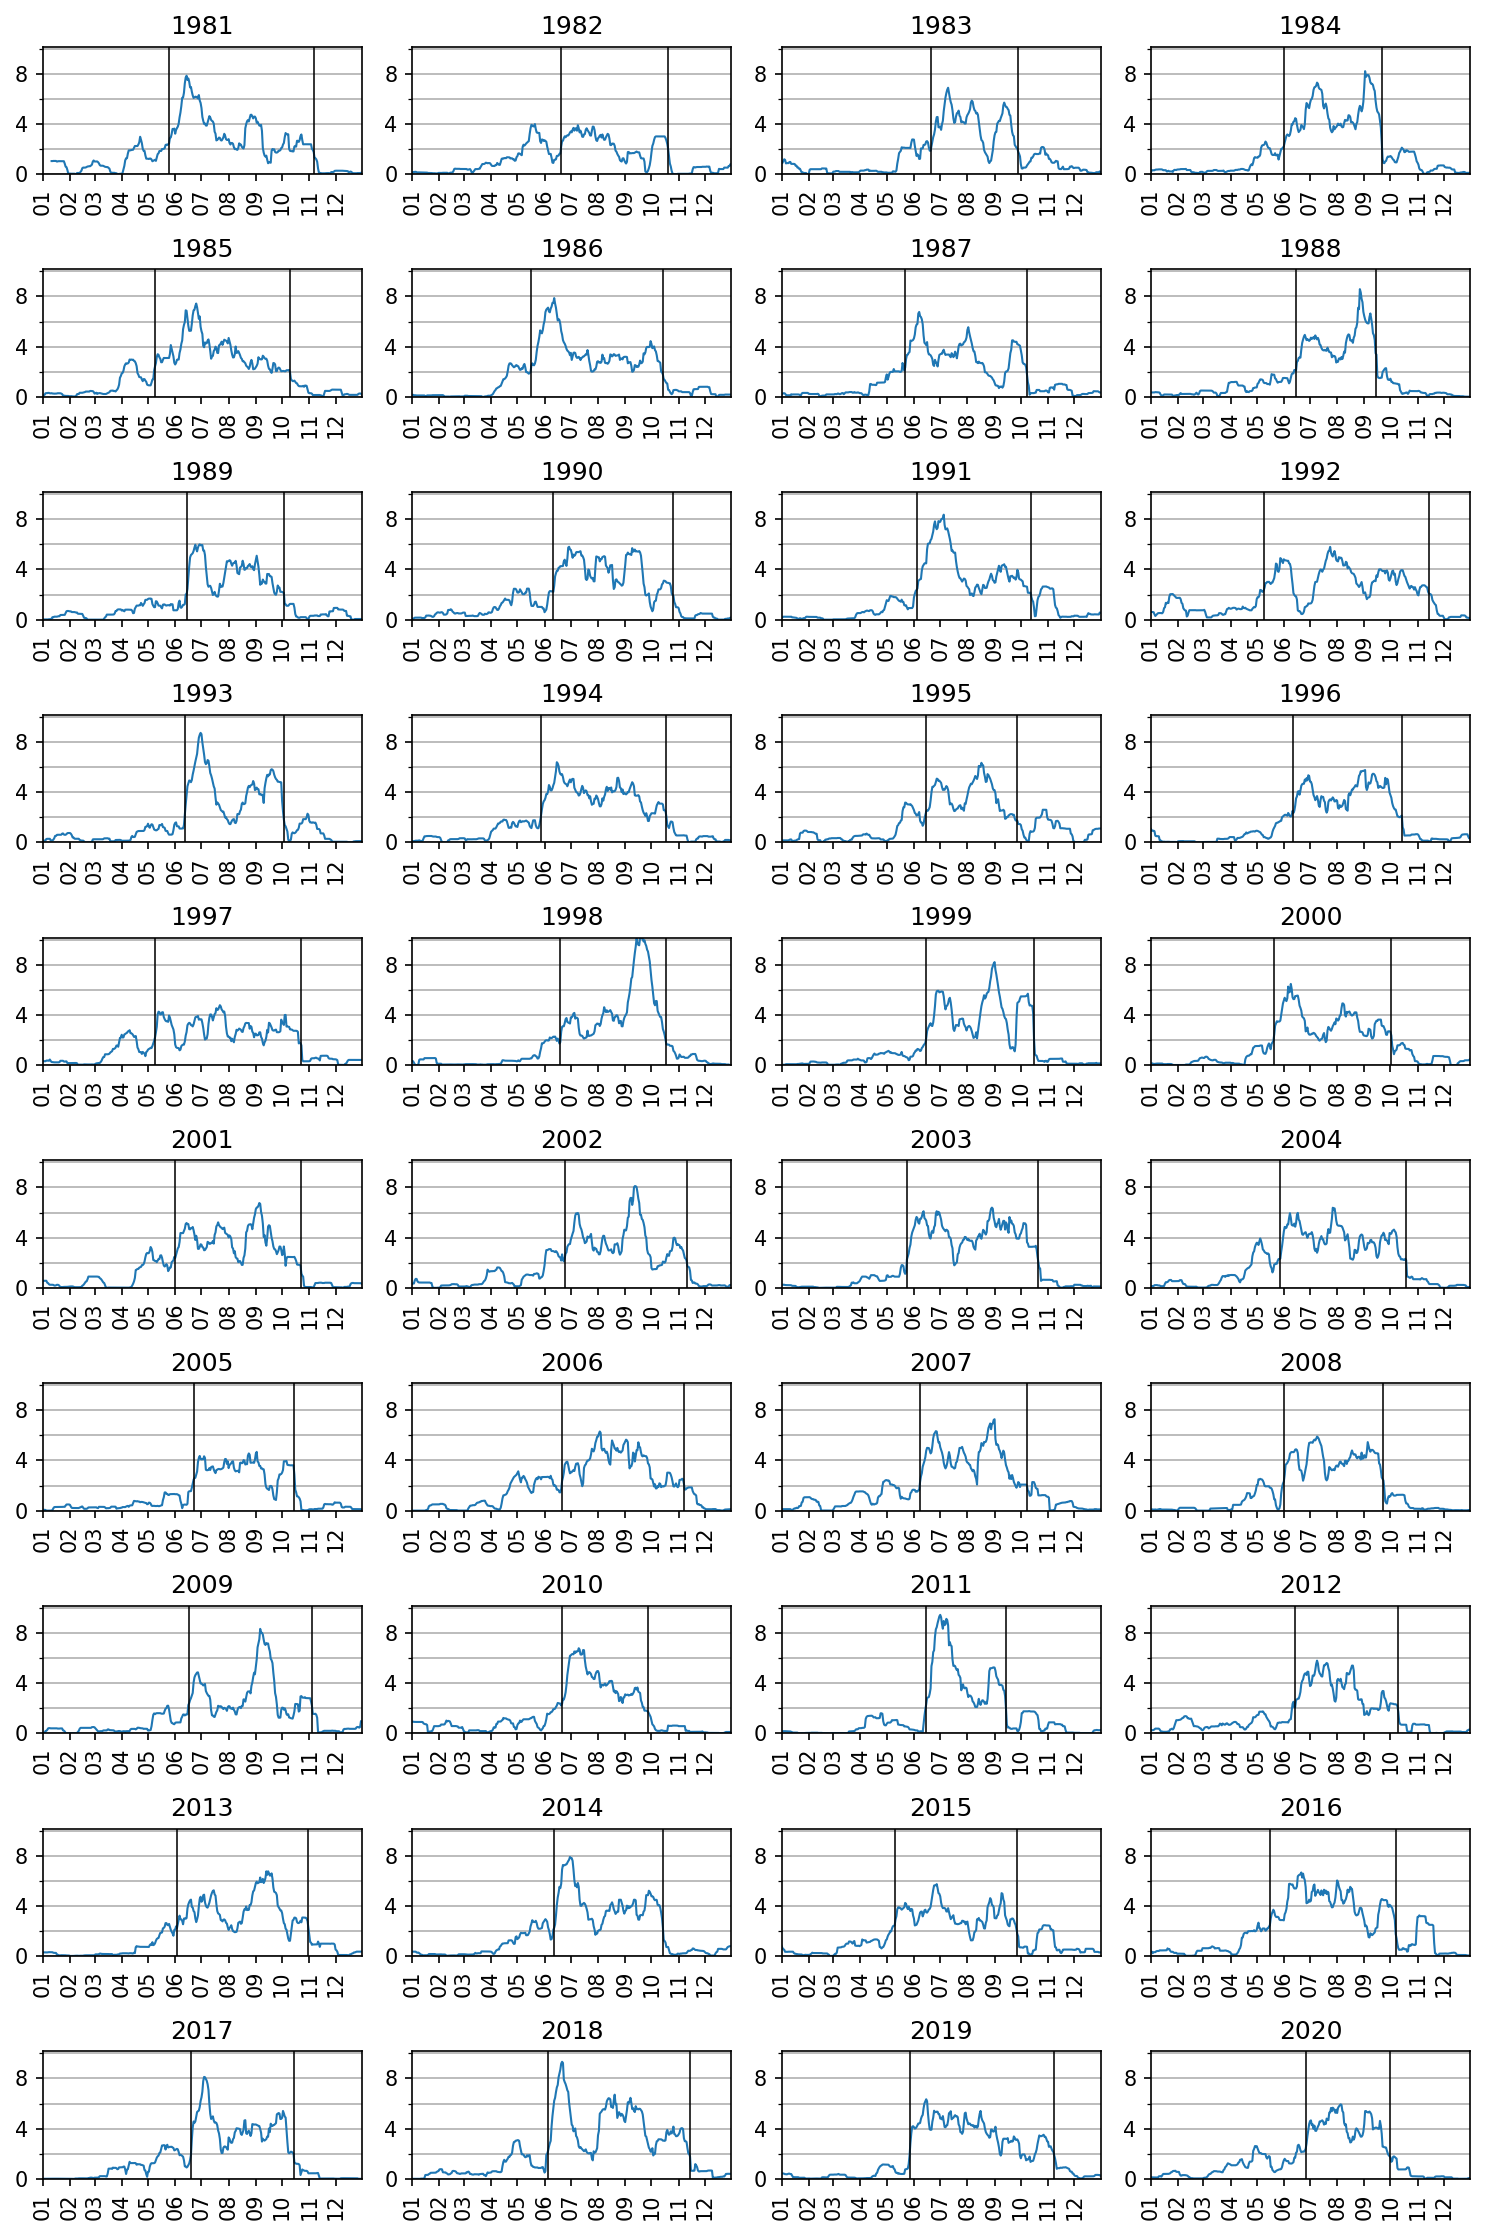

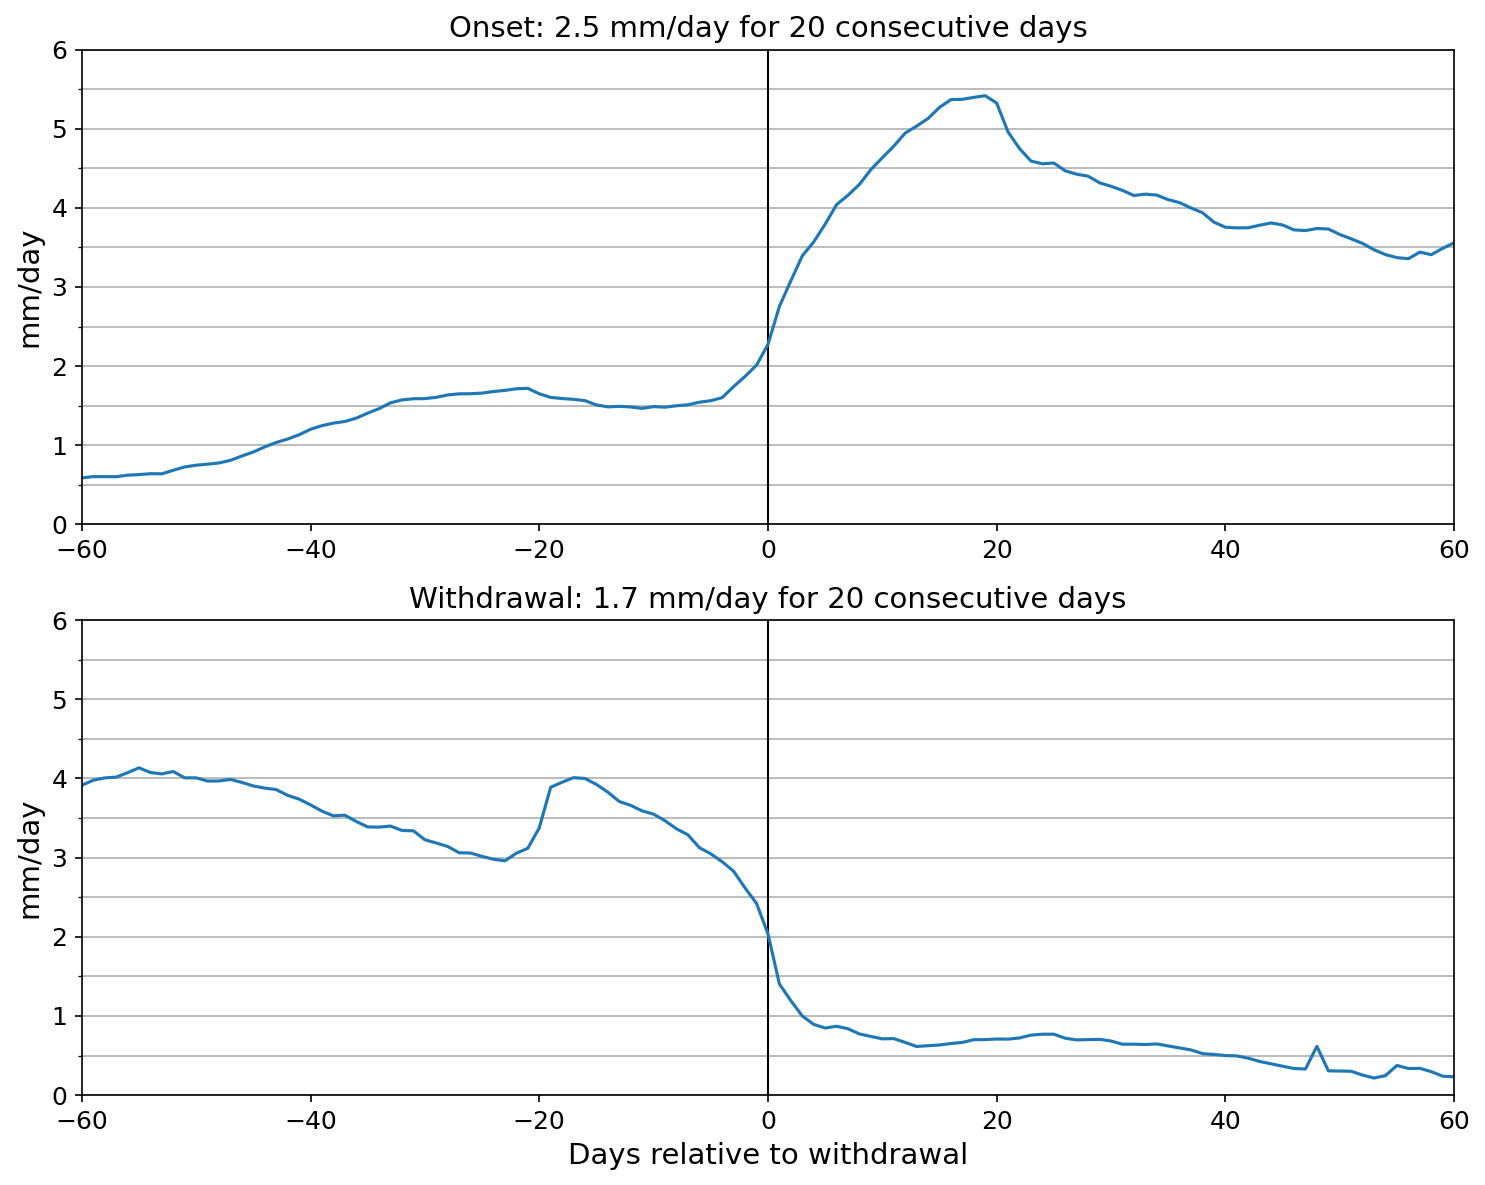

In [5]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.5, 1.7]
n = [20, 20]
# Inicio o fin de la racha de precipitación.
k = [0, 0]
for i in range( len(rec) ):
    if rec[i]:
        k[i] = n[i]
onset_n = ["Onset", "Withdrawal"]

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

years = range(year_r[0], year_r[1] + 1)
c = "Cuenca"
title = "onset_withdrawal_CHIRPS.png"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[0],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[0], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[0], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[0]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[0], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[0], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k[0] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k[0] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')

# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[1],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[1], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[1], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[1]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[1], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[1], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k[1] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k[1] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[1]: date_2.iloc[:, 1] = date_2.iloc[:, 1] + np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 1].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
date.to_csv(path_d + "onset_CHIRPS.csv")
shift.to_csv(path_d + "shift_CHIRPS.csv")
shift_2.to_csv(path_d + "shift_withdrawal_CHIRPS.csv")

year = range(year_r[0], year_r[1] + 1)

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim( df_mean.min().values[0], df_mean.max().values[0])
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + title )


# Composite.

# Cantidad de días a recorrer.
delta = shift.max()
delta_2 = shift_2.max()
shift = delta - shift
shift_2 = delta_2 - shift_2

# Graficamos.
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
fig.set_size_inches(10, 8)
fig.set_dpi(150)

shift_o = [shift, shift_2]
delta_o = [delta, delta_2]

# Creamos un DataFrame con año
# como columnas y días como filas.
pre_df = pd.DataFrame( df_mean.copy(), columns = [ df_mean.columns[0] ] )
pre_df["Año"] = pre_df.index.year
pre_df["Día"] = pre_df.index.dayofyear

# Convertimos los años a columnas.
pre_df = pre_df.pivot(index = "Día", columns = "Año")
pre_df.columns = pre_df.columns.droplevel(0)

# Eliminamos el 2021.
pre_df = pre_df.iloc[:, :-1]

for i in [0, 1]:
    pre_df_2 = pre_df.copy()

    # Alineamos las series de tiempo.
    for j in pre_df_2.columns:
        pre_df_2[j] = pre_df_2[j].shift(shift_o[i][j])

    # Promediamos y seleccionamos 120 días.
    pre_df_2 = pre_df_2.mean(axis = 1)
    if i == 1:
        a = pre_df_2[0:60]
        a.index = np.arange(367, 367 + 60)
        pre_df_2 = pre_df_2.append(a)
    pre_df_2 = pre_df_2.loc[delta_o[i] - 60: delta_o[i] + 60]
    pre_df_2.index = range(-60, 61)

    # Graficamos.
    axes[i].plot( (0, 0), (0, 7), color = "k", linewidth = 1 )
    pre_df_2.plot(ax = axes[i])

    axes[i].set_title( ( f"{onset_n[i]}: {umbral[i]} "
        + f"mm/day for {n[i]} consecutive days" ), fontsize = 14 )
    axes[i].tick_params(axis = "both", which = "major", labelsize = 12 )
    axes[i].set_xlim(-60, 60)
    axes[i].set_ylim(0, lim)

    # Pendiente del incremento de lluvia.
    y_1 = pre_df_2.loc[-1]
    y_2 = pre_df_2.loc[ 1]
    x_1 = -1
    x_2 =  1
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    print( f"Umbral: {umbral[i]} mm/día, {n[i]} días consecutivos, " + 
        f"Pendiente: {m:.3f}" )
    #axes[i].plot( ( x_1 + ( 0 - y_1 ) / m, 
    #    x_1 + ( lim - y_1 ) / m ), (0, lim),
    #    color = "orange", linewidth = 2 )
    #axes[i].plot( x_1, y_1, marker = "x",
    #    markersize = 10, mew = 2, color = "r" )
    #axes[i].plot( x_2, y_2, marker = "x",
    #    markersize = 10, mew = 2, color = "r" )

    axes[i].set_ylabel("mm/day", fontsize = 14)
    if i == 1: axes[i].set_xlabel( "Days relative to " + onset_n[i].lower(),
        fontsize = 14 )

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        ax.grid( visible = True, which = "both", axis ="y" )

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    fig.savefig( path_r + "composite_pre_CHIRPS.png" )

date_2 = date.copy()
date_2.iloc[:, 0] = date_2.iloc[:, 0].apply(
    lambda x: x.dayofyear - x.is_leap_year )
date_2.iloc[:, 1] = date_2.iloc[:, 1].apply(
    lambda x: x.dayofyear - x.is_leap_year )

stats = date_2.describe()

stats["Onset - date"] = pd.to_datetime(stats.iloc[:, 0], unit = "D")
stats["Withdrawal - date"] = pd.to_datetime(stats.iloc[:, 1], unit = "D")

stats

In [6]:
date_2.sort_values("Cuenca - Onset", ascending = False).head()

,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length
Año,,,
2020,177,274,97 days
2002,175,315,140 days
2005,173,288,115 days
2010,172,270,98 days
1983,172,271,99 days


In [7]:
date.loc[1992]

Cuenca - Onset         1992-05-09 00:00:00
Cuenca - Withdrawal    1992-11-14 00:00:00
Cuenca - Length          189 days 00:00:00
Name: 1992, dtype: object

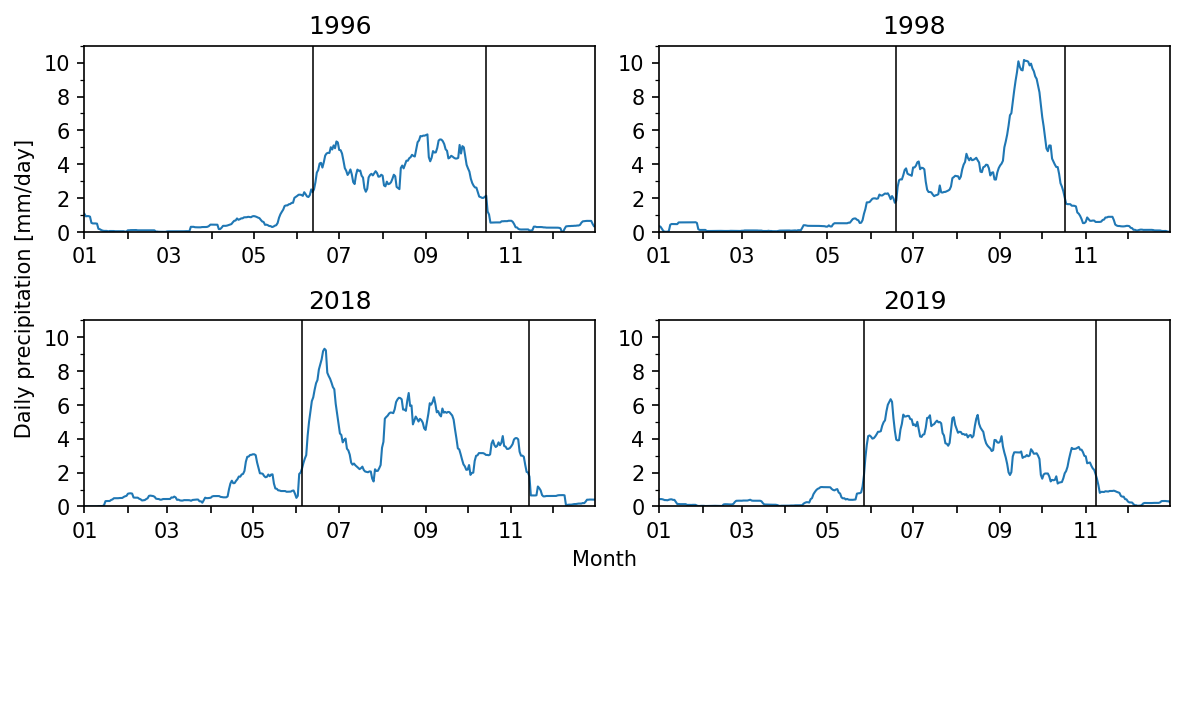

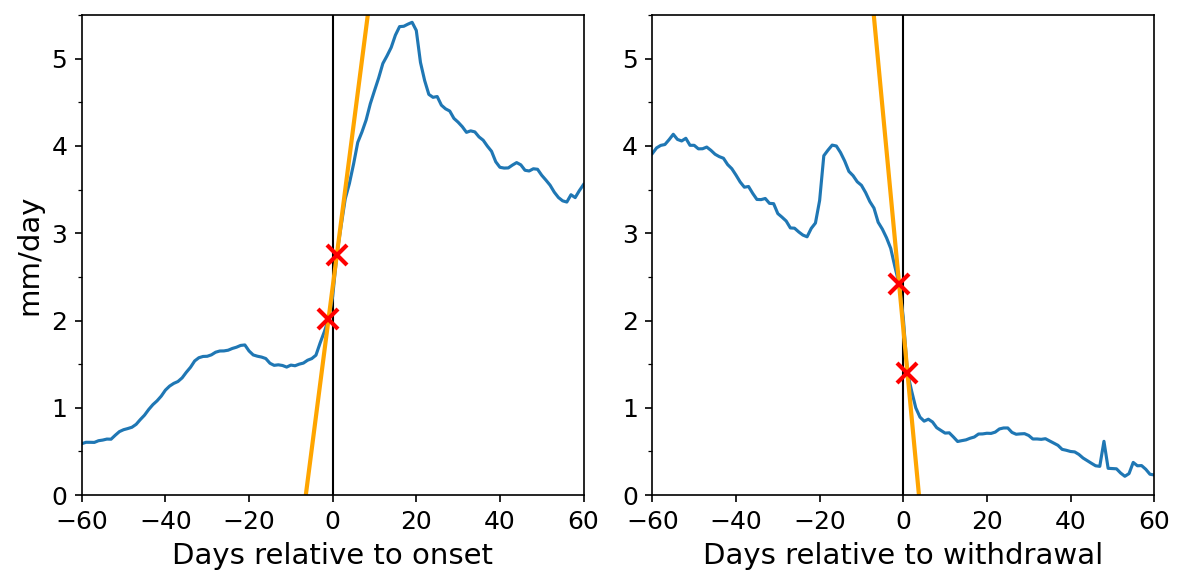

In [8]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.5, 1.7]
n = [20, 20]
# Inicio o fin de la racha de precipitación.
k = [0, 0]
for i in range( len(rec) ):
    if rec[i]:
        k[i] = n[i]
onset_n = ["Onset", "Withdrawal"]

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

years = range(year_r[0], year_r[1] + 1)
c = "Cuenca"
title = "onset_withdrawal_CHIRPS.pdf"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[0],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[0], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[0], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[0]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[0], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[0], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k[0] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k[0] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')

# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[1],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[1], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[1], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[1]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[1], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[1], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k[1] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k[1] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[1]: date_2.iloc[:, 1] = date_2.iloc[:, 1] + np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 1].apply(lambda x: x.dayofyear)

year = [1996, 1998, 2018, 2019]

# Graficamos.
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150)

xtick_lab = [ "01", "", "03", "", "05", "", "07", "", "09", "", "11", ""]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 2), minor = False )
    axes[i].set_yticks( range(0, 14, 1), minor = True)
    if i != 0: axes[i].set_yticklabels( [""] * 14, minor = True)
    #axes[i].grid(axis = "y", which = "both")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim( 0, 11)
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    #axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 0 )

axes[2].set_ylabel(
    "                                      Daily precipitation [mm/day]")
axes[2].set_xlabel( "               " + 
    "                                                                 Month")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + title )


# Composite.

# Cantidad de días a recorrer.
delta = shift.max()
delta_2 = shift_2.max()
shift = delta - shift
shift_2 = delta_2 - shift_2

# Graficamos.
fig, axes = plt.subplots(1, 2)
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150)

shift_o = [shift, shift_2]
delta_o = [delta, delta_2]

# Creamos un DataFrame con año
# como columnas y días como filas.
pre_df = pd.DataFrame( df_mean.copy(), columns = [ df_mean.columns[0] ] )
pre_df["Año"] = pre_df.index.year
pre_df["Día"] = pre_df.index.dayofyear

# Convertimos los años a columnas.
pre_df = pre_df.pivot(index = "Día", columns = "Año")
pre_df.columns = pre_df.columns.droplevel(0)

# Eliminamos el 2021.
pre_df = pre_df.iloc[:, :-1]

for i in [0, 1]:
    pre_df_2 = pre_df.copy()

    # Alineamos las series de tiempo.
    for j in pre_df_2.columns:
        pre_df_2[j] = pre_df_2[j].shift(shift_o[i][j])

    # Promediamos y seleccionamos 120 días.
    pre_df_2 = pre_df_2.mean(axis = 1)
    if i == 1:
        a = pre_df_2[0:60]
        a.index = np.arange(367, 367 + 60)
        pre_df_2 = pre_df_2.append(a)
    pre_df_2 = pre_df_2.loc[delta_o[i] - 60: delta_o[i] + 60]
    pre_df_2.index = range(-60, 61)

    # Graficamos.
    axes[i].plot( (0, 0), (0, 7), color = "k", linewidth = 1 )
    pre_df_2.plot(ax = axes[i])

    axes[i].tick_params(axis = "both", which = "major", labelsize = 12 )
    axes[i].set_xlim(-60, 60)
    axes[i].set_ylim(0, 5.5)

    # Pendiente del incremento de lluvia.
    y_1 = pre_df_2.loc[-1]
    y_2 = pre_df_2.loc[ 1]
    x_1 = -1
    x_2 =  1
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    axes[i].plot( ( x_1 + ( 0 - y_1 ) / m, 
        x_1 + ( lim - y_1 ) / m ), (0, lim),
        color = "orange", linewidth = 2 )
    axes[i].plot( x_1, y_1, marker = "x",
        markersize = 10, mew = 2, color = "r" )
    axes[i].plot( x_2, y_2, marker = "x",
        markersize = 10, mew = 2, color = "r" )

    if i == 0: 
        axes[i].set_ylabel("mm/day", fontsize = 14)

    axes[i].set_xlabel( "Days relative to " + onset_n[i].lower(),
        fontsize = 14 )

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        #ax.grid( visible = True, which = "both", axis ="y" )

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    fig.savefig( path_r + "composite_pre_CHIRPS.pdf" )

date_2 = date.copy()
date_2.iloc[:, 0] = date_2.iloc[:, 0].apply(lambda x: x.dayofyear)
date_2.iloc[:, 1] = date_2.iloc[:, 1].apply(lambda x: x.dayofyear)

stats = date_2.describe()

stats["Onset - date"] = pd.to_datetime(stats.iloc[:, 0], unit = "D")
stats["Withdrawal - date"] = pd.to_datetime(stats.iloc[:, 1], unit = "D")

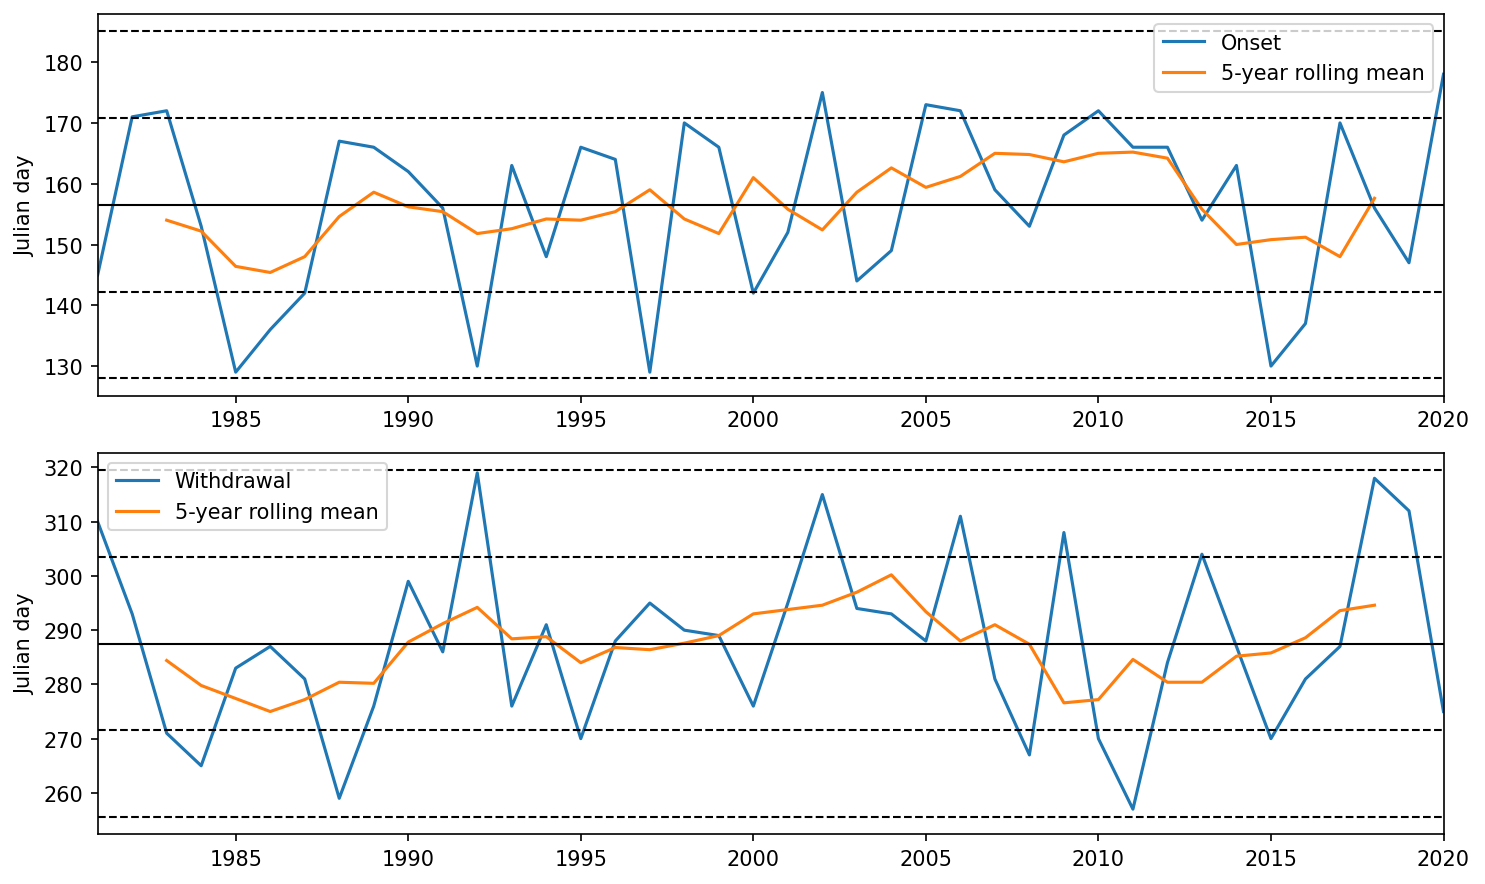

In [9]:
# Serie de tiempo de onset y withdrawal.

# Graficamos.
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
fig.set_size_inches(10, 6)
fig.set_dpi(150)

# Formato de ejes.
for i in range(len(axes)):
    
    date_2.iloc[:, i].plot(ax = axes[i])
    media_5[i] = date_2.iloc[:, i].rolling( window = 5, center = True ).mean()
    media_5[i].plot(ax = axes[i])
    axes[i].set_ylabel("Julian day")
    axes[i].set_xlabel("")
    axes[i].legend([onset_n[i], "5-year rolling mean"])
    axes[i].set_xlim(*year_r)
    
    # Media.
    axes[i].plot( year_r, (stats.iloc[1, i],)*2,
        color = "k", linewidth = 1 )

    # Desviación estándar.
    axes[i].plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    axes[i].plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    axes[i].plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    axes[i].plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_onset_withdrawal.png")

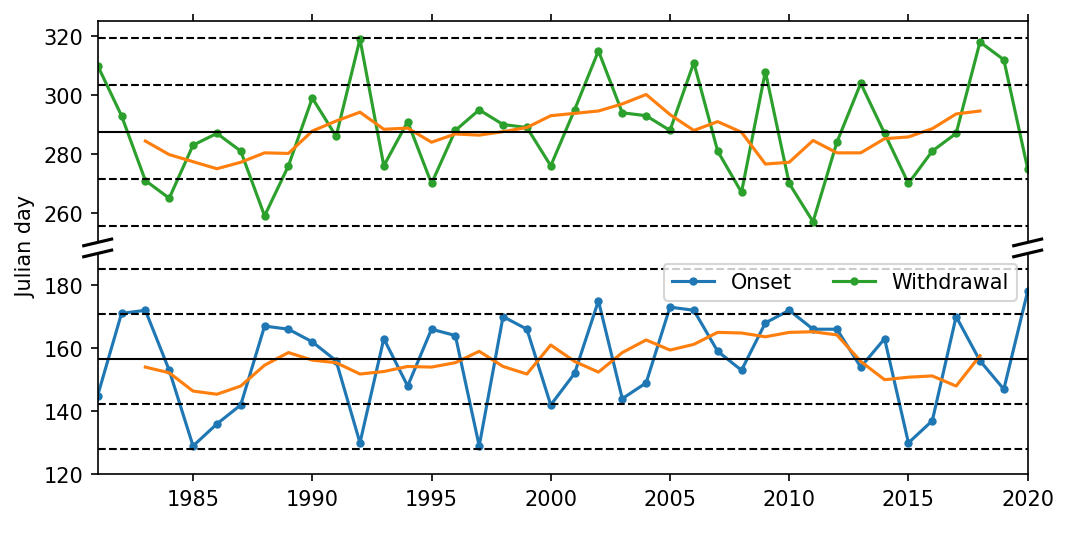

In [10]:
# Serie de tiempo de onset y withdrawal.

# Graficamos.
fig, (ax2, ax1) = plt.subplots(2, 1, sharex = True)
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150)

#ax.set_ylabel("Julian day")
ax1.set_xlim(*year_r)
ax2.set_xlim(*year_r)

color = ["tab:blue", "tab:green"]

# Formato de ejes.
for i in range(len(axes)):
    
    date_2.iloc[:, i].plot(style = ".-", ax = ax1, color = color[i])
    date_2.iloc[:, i].plot(style = ".-", ax = ax2, color = color[i])
    media_5[i] = date_2.iloc[:, i].rolling( window = 5, center = True ).mean()
    media_5[i].plot(ax = ax1, color = "tab:orange")
    media_5[i].plot(ax = ax2, color = "tab:orange")
    
    # Media.
    ax1.plot( year_r, (stats.iloc[1, i],)*2, color = "k", linewidth = 1 )
    ax2.plot( year_r, (stats.iloc[1, i],)*2, color = "k", linewidth = 1 )

    # Desviación estándar.
    ax1.plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax1.plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax1.plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax1.plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    
    ax2.plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax2.plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax2.plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    ax2.plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i] * 2, ) * 2,
        color = "k", linestyle = "dashed", linewidth = 1 )

ax1.set_ylim(120, 190)
ax2.set_ylim(250, 325)

# hide the spines between ax and ax2
ax2.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.xaxis.tick_top()
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax1.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.legend([onset_n[0]] +  ["_"] * 6 + [onset_n[1]], ncol = 2)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

fig.subplots_adjust(hspace=.05)

ax1.set_ylabel("                                    Julian day")

# Separación adecuada entre gráficas.
#fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_onset_withdrawal_eje_roto.pdf")

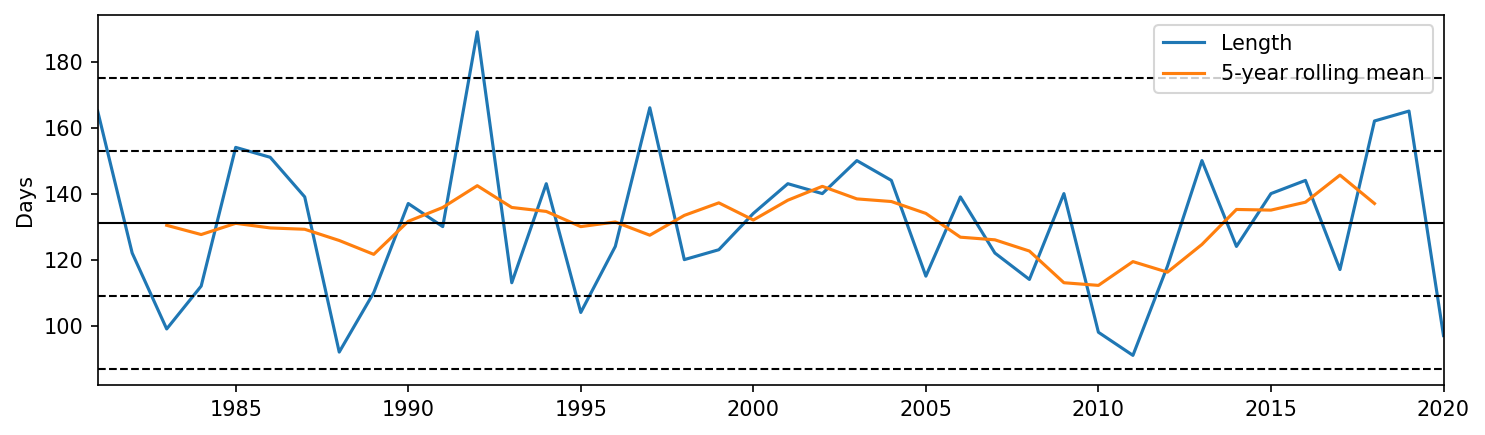

In [11]:
# Serie de tiempo de duración.

# Graficamos.

fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

# Formato de ejes.
date_2.iloc[:, 2].dt.days.plot(ax = ax)
media_5[2] = date_2.iloc[:, 2].dt.days.rolling(
    window = 5, center = True ).mean()
media_5[2].plot(ax = ax)
ax.set_ylabel("Days")
ax.set_xlabel("")
ax.legend(["Length", "5-year rolling mean"])
ax.set_xlim(*year_r)

ax.plot( year_r, (stats.iloc[1, 2].days,)*2, color = "k", linewidth = 1 )

# Desviación estándar.
ax.plot( year_r, (stats.iloc[1, 2].days - stats.iloc[2, 2].days,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days + stats.iloc[2, 2].days,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days - stats.iloc[2, 2].days*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days + stats.iloc[2, 2].days*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_duración.png")

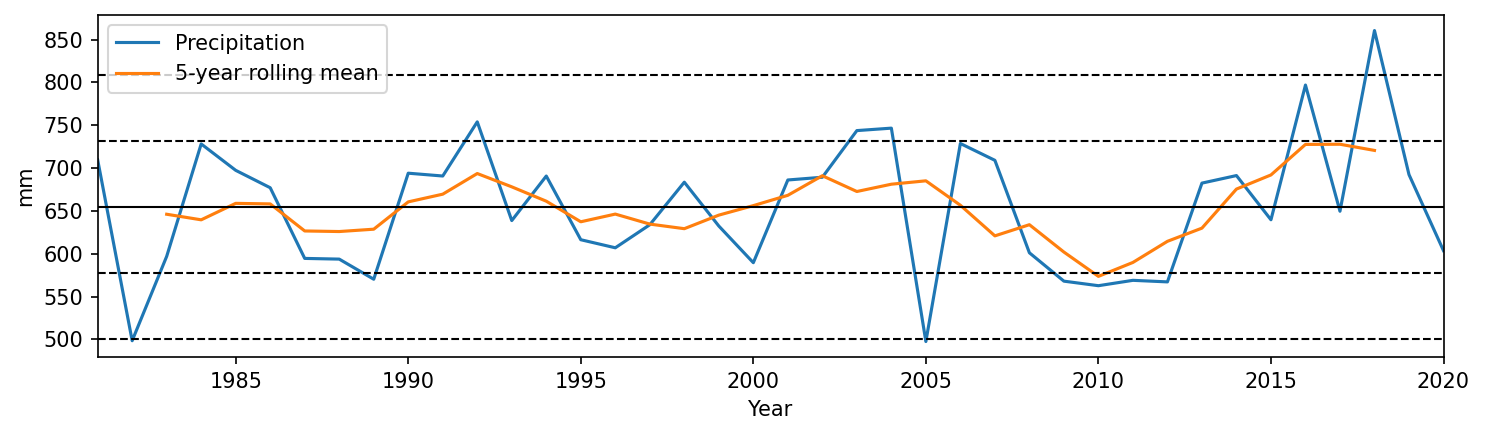

In [12]:
# Serie de tiempo de precipitación.

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

pre = df.groupby(df.index.year).sum()
stats_pre = pre.describe()

# Formato de ejes.
pre["Cuenca"].plot(ax = ax)
media_5[3] = pre["Cuenca"].rolling(window = 5, center = True).mean()
media_5[3].plot(ax = ax)
ax.set_ylabel("mm")
ax.set_xlabel("Year")
ax.legend(["Precipitation", "5-year rolling mean"])
ax.set_xlim(*year_r)

# Media.
ax.plot( year_r, (stats_pre.iloc[1, 0],)*2, color = "k", linewidth = 1 )

# Desviación estándar.
ax.plot( year_r, (stats_pre.iloc[1, 0] - stats_pre.iloc[2, 0],)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] + stats_pre.iloc[2, 0],)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] - stats_pre.iloc[2, 0]*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] + stats_pre.iloc[2, 0]*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_precipitacion.png")

In [13]:
# Precipitación dentro de la temporada de lluvias.

for j in date.index:
    year = df[ df.index.year.isin( [j] ) ]

    # Precipitación entre onset y withdrawal.
    for i in year.iterrows():
        if ( ( i[0] < date.loc[j, "Cuenca - Onset"] )
            or ( i[0] > date.loc[j, "Cuenca - Withdrawal"] ) ): 
            year.loc[ i[0] ] = 0

    pre.loc[j] = year.sum()

media_5[3] = pre["Cuenca"].rolling(window = 5, center = True).mean()

      O_p_20    O_m_20  W_p_20    W_m_20  L_p_20    L_m_20  P_p_20    P_m_20
1988    True  0.304211    True  0.774737    True  0.470526    True  2.788078
1989    True  0.380451    True  0.906617    True  0.526165    True  2.761825
1990    True  0.478496    True  0.992632    True  0.514135    True  2.555073
1991    True  0.423609    True  0.912932    True  0.489323    True   2.73421
1992    True  0.359098    True  0.694135   False  0.335038    True  2.406794
1993    True  0.366165    True  0.533383   False  0.167218   False   1.31555
1994    True  0.449023    True  0.350977   False -0.098045   False  0.210892
1995    True  0.562556   False  0.000602    True -0.561955   False -1.192378
1996    True  0.650677   False -0.215789    True -0.866466   False -2.386492
1997    True  0.715789   False -0.256842    True -0.972632    True -3.020688
1998    True  0.695038   False -0.300602    True -0.995639    True -2.916491
1999    True  0.548271   False -0.415188    True -0.963459    True -2.942901

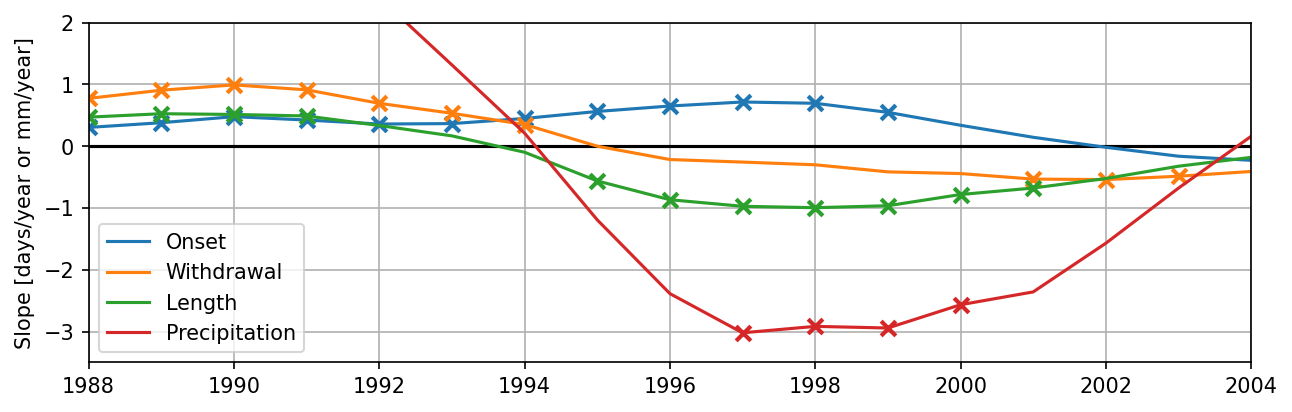

In [14]:
# Sliding trends.

alpha = 0.05
periods = [20]
units = "days"
color = [ "tab:" + x for x in [ "blue", "orange", "green", "red",
    "purple", "brown", "pink", "gray", "olive", "cyan" ] ]
tend_i = [None] * len(periods)
labels = ["Onset", "Withdrawal", "Length", "Precipitation"]
legend = ["_"]
tend_20 = pd.DataFrame(data = None, index = range(1988, 2004))

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

ax.plot((1981, 2020), (0, 0), color = "k")

for k in range(len(media_5)):

    tend[k] = pd.DataFrame( media_5[k].loc[1983:2018] )
    tend[k].columns = [1983]

    for i in range(tend[k].shape[0] - 1):
        tend[k][ tend[k].index[i + 1] ] = tend[k][ tend[k].index[i] ].shift(-1)

    for i in range(len(periods)):
        tend_i[i] = tend[k].iloc[ 0 : periods[i], : -periods[i] - 3 * i + 1 ]
        tend[k][f"{labels[k][0]}_p_{periods[i]}"] = False
        tend[k][f"{labels[k][0]}_m_{periods[i]}"] = None
        tend[k][f"{labels[k][0]}_r_{periods[i]}"] = None
        for j in tend_i[i].columns:
            reg = linregress(tend_i[i].index, tend_i[i][j])
            tend[k].loc[j, f"{labels[k][0]}_m_{periods[i]}"] = reg.slope
            tend[k].loc[j, f"{labels[k][0]}_r_{periods[i]}"] = reg.rvalue
            if reg.pvalue <= alpha:
                tend[k].loc[j, f"{labels[k][0]}_p_{periods[i]}"] = True

    tend[k].index += 5
    tend_20 = pd.concat( [ tend_20, tend[k].iloc[ : - periods[-1] + 1,
        - len(periods) * 3 : ] ], axis = 1 )

    tend_20.iloc[ :, 1 + k * 3 :: 3 ].plot(ax = ax)

    legend.append(labels[k])

    for i in tend_20.itertuples():
        # 30 o 20.
        for j in range(len(periods)):
            if i[1 + 3 * ( k + j ) ]:
                ax.scatter( i[0], i[2 + 3 * ( k + j ) ], marker = "x",
                    color = color[k], linewidth = 2, s = 50, zorder = 2 )
                legend.append("_")

ax.set_xlabel("")
ax.legend(legend)
ax.set_xlim(tend_20.index[0], tend_20.index[-1])
ax.set_ylim(-3.5, 2)
ax.set_ylabel(f"Slope [days/year or mm/year]")
ax.grid()

print(tend_20.iloc[:, [0, 1, 3, 4, 6, 7, 9, 10]])

     O_p_36    O_m_36 W_p_36    W_m_36 L_p_36    L_m_36 P_p_36    P_m_36
1988   True  0.200772  False  0.172355  False -0.028417  False  0.746672
1989    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1990    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1991    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1992    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1993    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1994    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1995    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1996    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1997    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1998    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
1999    NaN       NaN    NaN       NaN    NaN       NaN    NaN       NaN
2000    NaN       NaN    NaN       NaN    NaN      

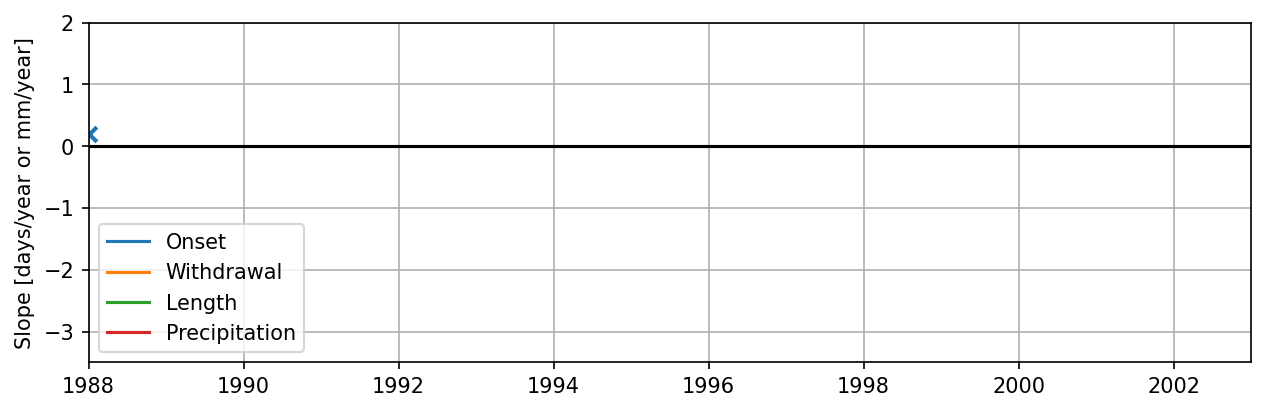

In [15]:
# Sliding trends.

alpha = 0.05
periods = [36]
units = "days"
color = [ "tab:" + x for x in [ "blue", "orange", "green", "red",
    "purple", "brown", "pink", "gray", "olive", "cyan" ] ]
tend_i = [None] * len(periods)
labels = ["Onset", "Withdrawal", "Length", "Precipitation"]
legend = ["_"]
tend_20 = pd.DataFrame(data = None, index = range(1988, 2004))

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

ax.plot((1981, 2020), (0, 0), color = "k")

for k in range(len(media_5)):

    tend[k] = pd.DataFrame( media_5[k].loc[1983:2018] )
    tend[k].columns = [1983]

    for i in range(tend[k].shape[0] - 1):
        tend[k][ tend[k].index[i + 1] ] = tend[k][ tend[k].index[i] ].shift(-1)

    for i in range(len(periods)):
        tend_i[i] = tend[k].iloc[ 0 : periods[i], : -periods[i] - 3 * i + 1 ]
        tend[k][f"{labels[k][0]}_p_{periods[i]}"] = False
        tend[k][f"{labels[k][0]}_m_{periods[i]}"] = None
        tend[k][f"{labels[k][0]}_r_{periods[i]}"] = None
        for j in tend_i[i].columns:
            reg = linregress(tend_i[i].index, tend_i[i][j])
            tend[k].loc[j, f"{labels[k][0]}_m_{periods[i]}"] = reg.slope
            tend[k].loc[j, f"{labels[k][0]}_r_{periods[i]}"] = reg.rvalue
            if reg.pvalue <= alpha:
                tend[k].loc[j, f"{labels[k][0]}_p_{periods[i]}"] = True

    tend[k].index += 5
    tend_20 = pd.concat( [ tend_20, tend[k].iloc[ : - periods[-1] + 1,
        - len(periods) * 3 : ] ], axis = 1 )

    tend_20.iloc[ :, 1 + k * 3 :: 3 ].plot(ax = ax)

    legend.append(labels[k])

    for i in tend_20.itertuples():
        # 30 o 20.
        for j in range(len(periods)):
            if i[1 + 3 * ( k + j ) ]:
                ax.scatter( i[0], i[2 + 3 * ( k + j ) ], marker = "x",
                    color = color[k], linewidth = 2, s = 50, zorder = 2 )
                legend.append("_")

ax.set_xlabel("")
ax.legend(legend)
ax.set_xlim(tend_20.index[0], tend_20.index[-1])
ax.set_ylim(-3.5, 2)
ax.set_ylabel(f"Slope [days/year or mm/year]")
ax.grid()

print(tend_20.iloc[:, [0, 1, 3, 4, 6, 7, 9, 10]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


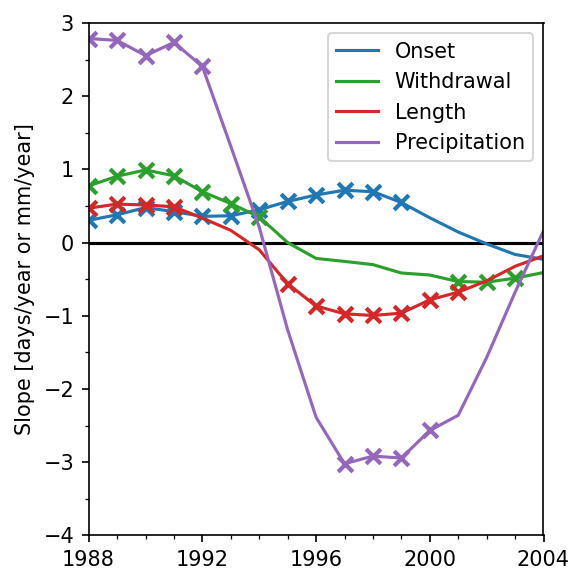

In [16]:
# Sliding trends.

alpha = 0.05
periods = [20]
units = "days"
color = [ "tab:" + x for x in [ "blue", "green", "red",
    "purple", "brown", "pink", "gray", "olive", "cyan" ] ]
tend_i = [None] * len(periods)
labels = ["Onset", "Withdrawal", "Length", "Precipitation"]
legend = ["_"]
tend_20 = pd.DataFrame(data = None, index = range(1988, 2004))

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(4, 4)
fig.set_dpi(150)

ax.plot((1981, 2020), (0, 0), color = "k")

for k in range(len(media_5)):
    # tabla para serie de regresión y valores.
    tend[k] = pd.DataFrame( media_5[k].loc[1983:2018] )
    tend[k].columns = [1983]

    # Recorremos el periodo.
    for i in range(tend[k].shape[0] - 1):
        tend[k][ tend[k].index[i + 1] ] = tend[k][ tend[k].index[i] ].shift(-1)

    for i in range(len(periods)):
        # serie para regresión.
        tend_i[i] = tend[k].iloc[ 0 : periods[i], : -periods[i] - 3 * i + 1 ]
        tend[k][f"{labels[k][0]}_p_{periods[i]}"] = False
        tend[k][f"{labels[k][0]}_m_{periods[i]}"] = None
        tend[k][f"{labels[k][0]}_r_{periods[i]}"] = None
        # Regresión lineal.
        for j in tend_i[i].columns:
            reg = linregress(tend_i[i].index, tend_i[i][j])
            tend[k].loc[j, f"{labels[k][0]}_m_{periods[i]}"] = reg.slope
            tend[k].loc[j, f"{labels[k][0]}_r_{periods[i]}"] = reg.rvalue
            if reg.pvalue <= alpha:
                tend[k].loc[j, f"{labels[k][0]}_p_{periods[i]}"] = True

    tend[k].index += 5
    # Serie de tendencias.
    tend_20 = pd.concat( [ tend_20, tend[k].iloc[ : - periods[-1] + 1,
        - len(periods) * 3 : ] ], axis = 1 )

    # Graficamos serie.
    tend_20.iloc[ :, 1 + k * 3 :: 3 ].plot(ax = ax, color = color[k])

    legend.append(labels[k])

    # Graficamos significancia.
    for i in tend_20.itertuples():
        # 30 o 20.
        for j in range(len(periods)):
            if i[1 + 3 * ( k + j ) ]:
                ax.scatter( i[0], i[2 + 3 * ( k + j ) ], marker = "x",
                    color = color[k], linewidth = 2, s = 50, zorder = 2 )
                legend.append("_")
ax.set_xlabel("")
ax.legend(legend)
ax.set_xlim(1988, 2004)
ax.set_ylim(-4, 3)

    
#ax.grid(axis = "x", which = "both")
#ax.grid(axis = "y", which = "both")
ax.set_yticks(np.arange(-4, 3.5, 1))
ax.set_yticks(np.arange(-4, 3.5, 0.5), minor = True )
ax.set_xticks(np.arange(1988, 2008, 4))
ax.set_xticks(np.arange(1988, 2004, 1), minor = True )

ax.set_ylabel(f"Slope [days/year or mm/year]")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_tendencia.eps")

         O: c   O: s      W: c   W: s      L: c   L: s      P: c   P: s
Lag                                                                    
1    0.729966   True  0.798727   True  0.766842   True  0.843141   True
2    0.476943   True  0.554784   True  0.528295   True   0.56777   True
3     0.37503   True   0.37934   True  0.276185  False  0.226972  False
4    0.167391  False   0.12733  False -0.071168  False -0.092448  False
5   -0.048695  False -0.236627  False -0.336554  False -0.386106   True
6   -0.017803  False -0.367166   True -0.409567   True -0.538532   True
7    0.013674  False -0.407542   True  -0.54341   True -0.676582   True
8   -0.064188  False   -0.4293   True -0.560971   True -0.704911   True
9   -0.155782  False -0.329555  False -0.412162   True -0.606476   True
10  -0.203717  False -0.133395  False -0.334708  False -0.397669   True


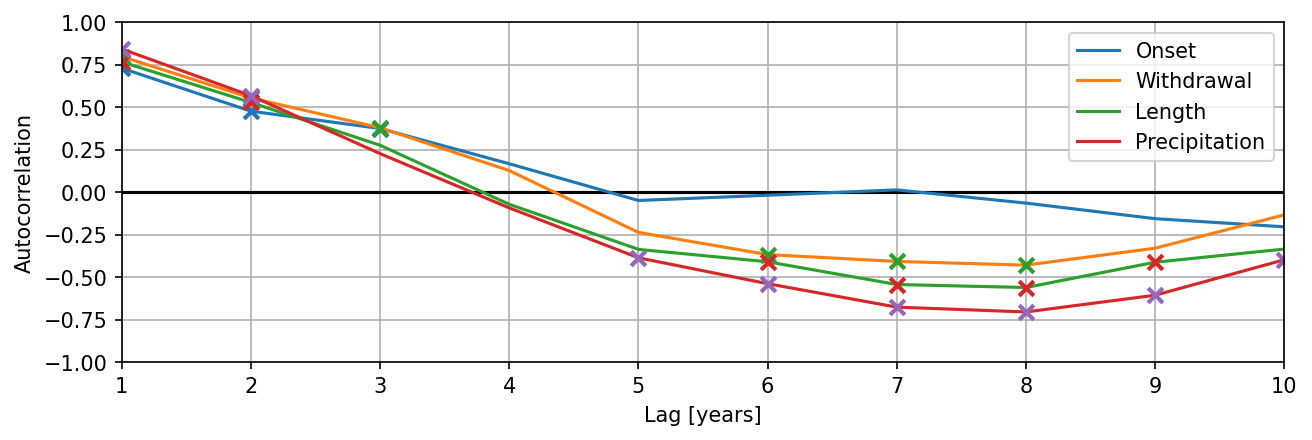

In [17]:
# Autocorrelación

def pcorr(x, y, axis):
    if x.ndim == 1: 
        return pearsonr(x, y)[0]
    else:
        n = y.shape[0]
        statistic = np.empty( (n,) )
        for i in range(n): statistic[i], _ = pearsonr(x[i, :], y[i, :])
        return statistic

legend = ["_"]

column_a = [x[0] + ": c" for x in labels]
column_b = [x[0] + ": s" for x in labels]
columns = []
for i in range(len(column_a)):
    columns.append(column_a[i])
    columns.append(column_b[i])

autocorr = pd.DataFrame(data = [ [None] * len(columns) ] * 10,
    index = range(1, 11), columns = columns )
autocorr.index.name = "Lag"

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

ax.plot((1, 10), (0, 0), color = "k")

for k in range(len(tend)):

    legend.append(labels[k])

    tend_auto = tend[k].iloc[:, : - len(periods) * 3 ]

    for i in autocorr.index:
        corr, _ = pearsonr(tend_auto.iloc[:-i, 0], tend_auto.iloc[:-i, i])

        int = bootstrap( [ tend_auto.iloc[:-i, 0], tend_auto.iloc[:-i, i] ],
            pcorr, confidence_level = 0.95, method = "basic" 
            ).confidence_interval

        if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
        else: sig = False

        autocorr.iloc[i - 1, 2 * k] = corr
        autocorr.iloc[i - 1, 2 * k + 1] = sig

    autocorr.iloc[:, 2 * k].plot(ax = ax)

    for i in autocorr.itertuples():
        if i[2 * k + 2]:
            ax.scatter( i[0], i[2 * k + 1], marker = "x",
                color = color[k], linewidth = 2, s = 50, zorder = 2 )
            legend.append("_")

ax.legend(legend)
ax.set_xlim(autocorr.index[0], autocorr.index[-1])
ax.set_ylim(-1, 1)
ax.set_ylabel(f"Autocorrelation")
ax.set_xlabel("Lag [years]")
ax.grid()

print(autocorr)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


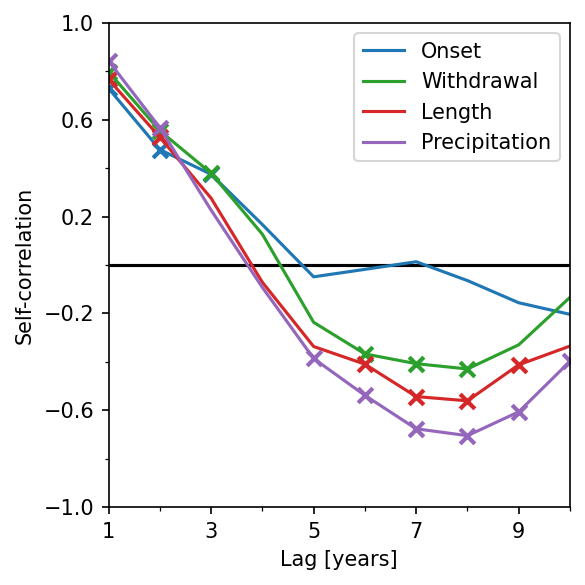

In [18]:
# Autocorrelación.

# Estadístico de prueba.
def pcorr(x, y, axis):
    if x.ndim == 1: 
        return pearsonr(x, y)[0]
    else:
        n = y.shape[0]
        statistic = np.empty( (n,) )
        for i in range(n): statistic[i], _ = pearsonr(x[i, :], y[i, :])
        return statistic

legend = ["_"]

# Valores de correlación y significancia.
column_a = [x[0] + ": c" for x in labels]
column_b = [x[0] + ": s" for x in labels]
columns = []
for i in range(len(column_a)):
    columns.append(column_a[i])
    columns.append(column_b[i])

# Tabla con valores de autocorelación.
autocorr = pd.DataFrame(data = [ [None] * len(columns) ] * 10,
    index = range(1, 11), columns = columns )
autocorr.index.name = "Lag"

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(4, 4)
fig.set_dpi(150)

ax.plot((1, 10), (0, 0), color = "k")

for k in range(len(tend)):

    legend.append(labels[k])

    # Series recorridas por lag.
    tend_auto = tend[k].iloc[:, : - len(periods) * 3 ]

    for i in autocorr.index:
        # Correlación.
        corr, _ = pearsonr(tend_auto.iloc[:-i, 0], tend_auto.iloc[:-i, i])

        # Bootstrapping.
        int = bootstrap( [ tend_auto.iloc[:-i, 0], tend_auto.iloc[:-i, i] ],
            pcorr, confidence_level = 0.95, method = "basic" 
            ).confidence_interval

        # Significativo.
        if ( corr <= int[0] ) or ( corr >= int[1] ): sig = True
        else: sig = False

        # Agregamos en la tabla.
        autocorr.iloc[i - 1, 2 * k] = corr
        autocorr.iloc[i - 1, 2 * k + 1] = sig

    # Graficamos serie.
    autocorr.iloc[:, 2 * k].plot(ax = ax, color = color[k])

    # Graficamos significancia.
    for i in autocorr.itertuples():
        if i[2 * k + 2]:
            ax.scatter( i[0], i[2 * k + 1], marker = "x",
                color = color[k], linewidth = 2, s = 50, zorder = 2 )
            legend.append("_")

ax.legend(legend)
ax.set_xlim(autocorr.index[0], autocorr.index[-1])
ax.set_ylim(-1, 1)
ax.set_ylabel(f"Self-correlation")
ax.set_xlabel("Lag [years]")

#ax.grid(axis = "x", which = "both")
#ax.grid(axis = "y", which = "both")
ax.set_yticks(np.arange(-1, 1.4, 0.4))
ax.set_yticks(np.arange(-1, 1, .2), minor = True )
ax.set_xticks(np.arange(1, 11, 2))
ax.set_xticks(np.arange(1, 11, 1), minor = True )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "serie_autocorr.eps")

In [19]:
# Valores anómalos y estadísticas de precipitación.

onset_el = [None] * 2
withdrawal_el = [None] * 2
length_el = [None] * 2
pre_el = [None] * 2

i = 0

onset_el[0] = date_2.loc[( date_2.iloc[:, i]
    < ( stats.iloc[1, i] - stats.iloc[2, i] )),
    date_2.columns[i]].index.values
onset_el[1] = date_2.loc[(date_2.iloc[:, i]
    > ( stats.iloc[1, i] + stats.iloc[2, i] )),
    date_2.columns[i]].index.values

i = 1

withdrawal_el[0] = date_2.loc[( date_2.iloc[:, i]
    < ( stats.iloc[1, i] - stats.iloc[2, i] )),
    date_2.columns[i]].index.values
withdrawal_el[1] = date_2.loc[(date_2.iloc[:, i]
    > ( stats.iloc[1, i] + stats.iloc[2, i] )),
    date_2.columns[i]].index.values

i = 2

length_el[0] = date_2.loc[( date_2.iloc[:, i].dt.days
    < ( stats.iloc[1, i].days - stats.iloc[2, i].days )),
    date_2.columns[i]].index.values
length_el[1] = date_2.loc[(date_2.iloc[:, i].dt.days
    > ( stats.iloc[1, i].days + stats.iloc[2, i].days )),
    date_2.columns[i]].index.values

pre_el[0] = pre[pre < ( stats_pre.iloc[1] - stats_pre.iloc[2] )
    ].dropna().index.values
pre_el[1] = pre[pre > ( stats_pre.iloc[1] + stats_pre.iloc[2] )
    ].dropna().index.values


print( ( "Onset\n" + f"Early dates: {onset_el[0]}\n"
    + f"Late dates: {onset_el[1]}\n" ) )
print( ( "Withdrawal\n" + f"Early dates: {withdrawal_el[0]}\n"
    + f"Late dates: {withdrawal_el[1]}\n" ) )
print( ( "Length\n" + f"Short dates: {length_el[0]}\n"
    + f"Long dates: {length_el[1]}\n" ) )
print( ( "Precipitation\n" + f"Low dates: {pre_el[0]}\n"
    + f"High dates: {pre_el[1]}" ) )

stats_pre 

Onset
Early dates: [1985 1986 1987 1992 1997 2000 2015 2016]
Late dates: [1982 1983 2002 2005 2006 2010 2020]

Withdrawal
Early dates: [1983 1984 1988 1995 2008 2010 2011 2015]
Late dates: [1981 1992 2002 2006 2009 2013 2018 2019]

Length
Short dates: [1983 1988 1995 2010 2011 2020]
Long dates: [1981 1985 1992 1997 2018 2019]

Precipitation
Low dates: [1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2017 2020]
High dates: []


,Cuenca
count,40.000000
mean,654.548340
std,77.103640
min,497.394220
25%,596.297837
50%,663.333400
75%,694.881022
max,860.685873


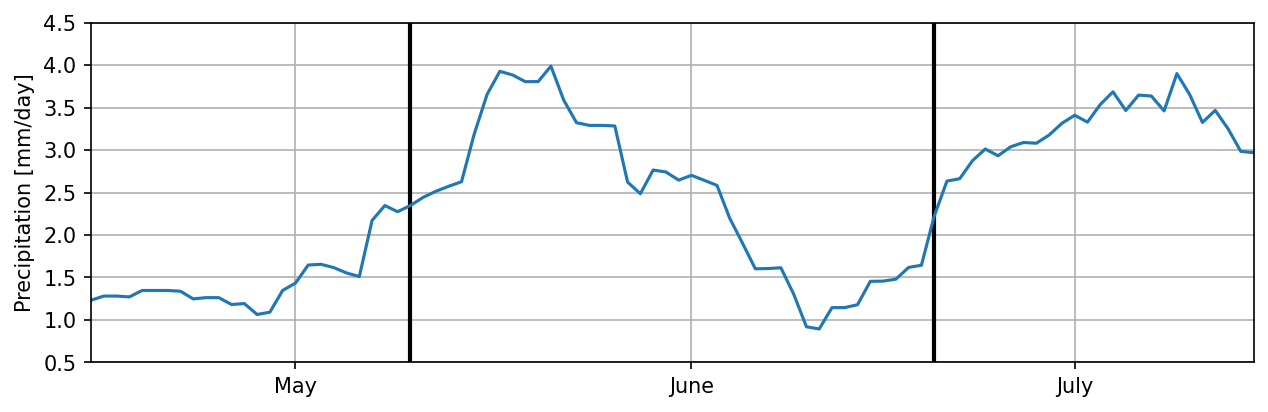

In [20]:
# Precipitación del año anómalo

year = 1982

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

# Escogemos mayo y junio.
a = df_mean_ind[ ( df_mean_ind.index.year == year )
    & df_mean_ind.index.month.isin([4, 5, 6, 7]) ].iloc[:, 0]

# Fechas propuestas de onset.
ax.plot( (pd.to_datetime("1982-05-10"), pd.to_datetime("1982-05-10")), (0, 5),
        color = "k", linewidth = 2 )
ax.plot( (pd.to_datetime("1982-06-20"), pd.to_datetime("1982-06-20")), (0, 5),
        color = "k", linewidth = 2 )

ax.plot(a)
ax.set_xlim( pd.to_datetime( str(year) + "-04-15" ),
    pd.to_datetime( str(year) + "-07-15") )
ax.set_ylim(0.5, 4.5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter(""))
ax.grid()
ax.set_ylabel("Precipitation [mm/day]")
ax.set_xticklabels( ["May", "June", "July"] );

In [21]:
# Rutas de archivos.
path_i = "../data/Indices/"

cols = ["Año"] + [i for i in range(1, 13)]
index = []
label = []
l = []

label.append("MEIV")
l.append(0)
index.append( pd.read_table( path_i + "MEIV", sep = "\s+",
    engine = "python", names = cols, index_col = 0,
    skiprows = 1, skipfooter = 4 ).loc[1981:2020].mean(axis = 1) )
label.append("PDO")
l.append(0)
index.append( pd.read_table( path_i + "PDO", sep = "\s+",
    engine = "python", names = cols, index_col = 0,
    skiprows = 2, skipfooter = 1 ).loc[1981:2020].mean(axis = 1) )

label.append("CLLJ")
l.append(0)
index.append( pd.read_csv( path_d + "CLLJ_index.csv",
    index_col = 0).loc[1981:2020].mean(axis = 1) )

colsst = ["Año", "Mes", "NINO1+2", "NINO1+2_ANOM", "NINO3", "NINO3_ANOM",
    "NINO4", "NINO4_ANOM", "NINO3.4", "NINO3.4_ANOM"]
a = pd.read_table( path_i + "SST", sep = "\s+",
    engine = "python", names = colsst, index_col = [0, 1],
    skiprows = 1, skipfooter = 4 ).loc[1981:2020].groupby("Año").mean()
label.append("NINO4")
l.append(1)
index.append( a.iloc[:, 5] )

(4018.0, 18597.0)

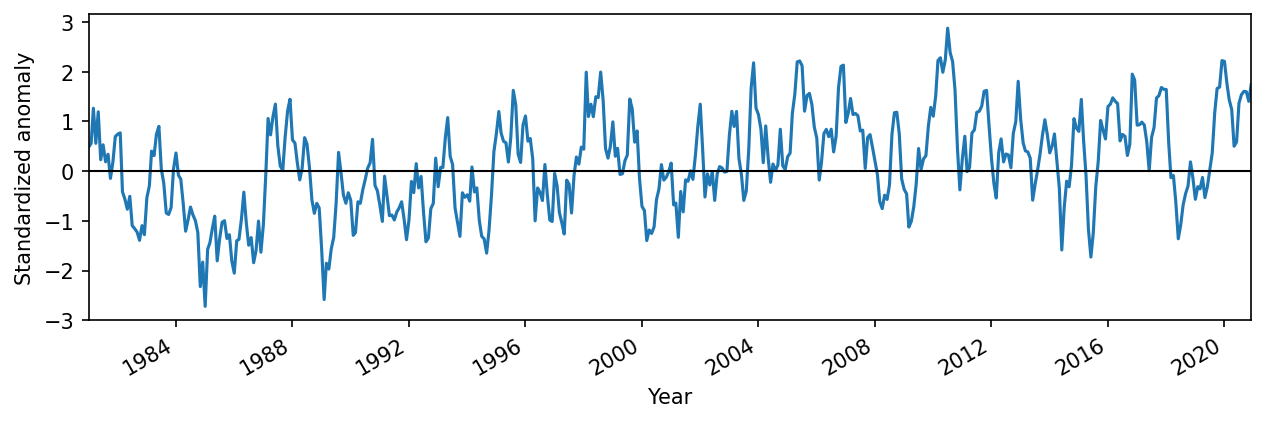

In [22]:
CLLJ = pd.read_csv( path_d + "CLLJ_index.csv",
    index_col = 0).loc[1981:2020]

CLLJ = CLLJ.reset_index().melt(id_vars = "Año").sort_values(
    "Año").reset_index(drop = True)
CLLJ.columns = ["YEAR", "MONTH", "CLLJ"]
CLLJ["Date"] = pd.to_datetime( CLLJ[ ["YEAR", "MONTH"] ].assign( DAY = 1 ) )
CLLJ.drop( ["YEAR", "MONTH"], axis = 1, inplace = True)
CLLJ.set_index("Date", inplace = True)

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

CLLJ["CLLJ"].plot(ax = ax)
ax.plot( [CLLJ.index[0], CLLJ.index[-1]], (0,)*2, color = "k", linewidth = 1 )

# Formato de ejes.
ax.set_ylabel("Standardized anomaly")
ax.set_xlabel("Year")
#ax.legend(["Precipitation", "5-year rolling mean"])
ax.set_xlim(CLLJ.index[0], CLLJ.index[-1])